In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt

from astropy.io import fits

In [2]:
nside = 1024

### Add mask, go to nside = 1024

In [204]:
mask_n = hp.read_map("mask_CMASS_DR12_nside1024_N_comp1_vetos1_resfac6_v2.fits")
mask_s = hp.read_map("mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits")

In [205]:
total_mask = hp.ud_grade(mask_n + mask_s, 1024)

In [206]:
hp.write_map("mask_CMASS_DR12_nside1024_total.fits", total_mask, overwrite=True)

setting the output map dtype to [dtype('float32')]


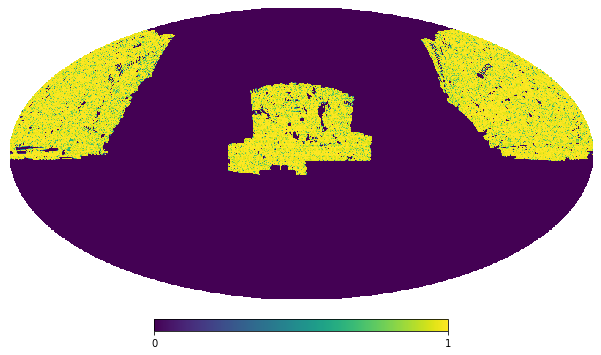

In [285]:
hp.mollview(total_mask, title="")

In [11]:
total_mask = hp.read_map("mask_CMASS_DR12_nside1024_total.fits")

In [12]:
fsky = np.sum(total_mask) / np.size(total_mask)
print(fsky)

0.2272769014040629


### Compute Clgg using NaMaster

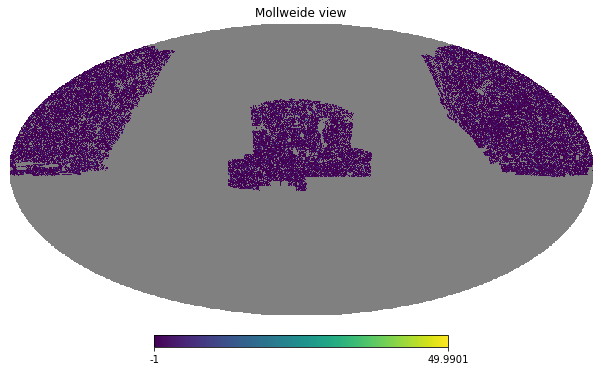

In [13]:
galaxy_map = hp.read_map("cmass_delta_map_nside1024.fits")
galaxy_masked_map = hp.read_map("cmass_delta_masked_map_nside1024.fits")
nside = hp.get_nside(galaxy_map)
hp.mollview(galaxy_masked_map)

In [3]:
galaxy_alm = hp.read_alm("galaxy_sims/cmass_galaxy_sims_1.fits")

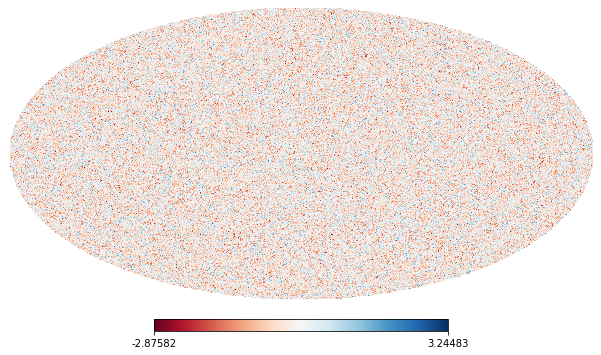

In [7]:
hp.mollview(hp.alm2map(galaxy_alm, 1024), cmap='RdBu', title='')

In [14]:
galaxy_map_catmapper = hp.read_map("cmass_delta_map_catmapper_nside1024.fits")

In [15]:
b = nmt.NmtBin.from_nside_linear(nside, 32)
print(b.get_effective_ells())

[  17.5   49.5   81.5  113.5  145.5  177.5  209.5  241.5  273.5  305.5
  337.5  369.5  401.5  433.5  465.5  497.5  529.5  561.5  593.5  625.5
  657.5  689.5  721.5  753.5  785.5  817.5  849.5  881.5  913.5  945.5
  977.5 1009.5 1041.5 1073.5 1105.5 1137.5 1169.5 1201.5 1233.5 1265.5
 1297.5 1329.5 1361.5 1393.5 1425.5 1457.5 1489.5 1521.5 1553.5 1585.5
 1617.5 1649.5 1681.5 1713.5 1745.5 1777.5 1809.5 1841.5 1873.5 1905.5
 1937.5 1969.5 2001.5 2033.5 2065.5 2097.5 2129.5 2161.5 2193.5 2225.5
 2257.5 2289.5 2321.5 2353.5 2385.5 2417.5 2449.5 2481.5 2513.5 2545.5
 2577.5 2609.5 2641.5 2673.5 2705.5 2737.5 2769.5 2801.5 2833.5 2865.5
 2897.5 2929.5 2961.5 2993.5 3025.5]


3.3649225556125797e-06


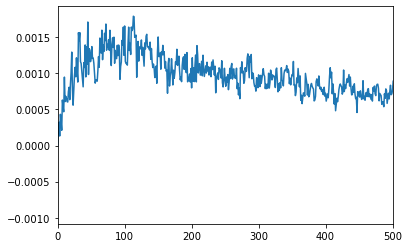

In [16]:
clgg_highell = hp.anafast(galaxy_masked_map, galaxy_masked_map, lmax=3*nside) / fsky
SN = np.mean(clgg_highell[-10:])
print(np.mean(clgg_highell[-10:]))
plt.xlim(0, 500)
plt.plot(np.arange(3073) * (clgg_highell - SN))

In [167]:
ws = np.loadtxt("galaxy_DR12v5_CMASS_both_weights.txt")
neff = np.sum(ws)**2 / (fsky * np.sum(ws**2))
analytic_sn = 4 * np.pi / neff

print(analytic_sn)

3.7408169856014395e-06


In [168]:
print(neff)

3359258.3285222603


In [99]:
1 / 300000

3.3333333333333333e-06

In [211]:
def compute_clgg(mask, imap, sn=SN, b=b, masked_on_input=False):
    g_field = nmt.NmtField(mask, [imap], masked_on_input=masked_on_input)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(g_field, g_field, b)
    ells = b.get_effective_ells()

    # compute binned pixwin
    bpws = w.get_bandpower_windows()[0,:,0,:]
    pixwin = np.interp(np.arange(bpws.shape[1]),
                       np.arange(3*hp.get_nside(total_mask)),
                       hp.pixwin(hp.get_nside(total_mask)),
                       right=0.5)

    pc1 = nmt.compute_coupled_cell(g_field, g_field)
    # shot noise subtraction
    clgg = w.decouple_cell(pc1)[0] - sn

    # deconvolve pixwin^2
    clgg *= np.dot(bpws, 1./pixwin**2)

    # add shot noise back in
    clgg += sn
    
    return ells, clgg

In [212]:
ells, clgg = compute_clgg(total_mask, galaxy_map, sn=analytic_sn)

In [263]:
np.savetxt("cmass_clgg_bandpowers.txt", np.column_stack((ells, clgg - analytic_sn)))

### compute Gaussian covariance

In [19]:
LperBins = (ells[1:] - ells[:-1])[0]
theory_err = (2. / (2 * ells + 1) * 1 / fsky * 1 / LperBins * clgg * clgg)**0.5

In [282]:
np.savetxt("cmass-theory-covariance-diag.txt", theory_err**2)

In [56]:
cov = np.loadtxt("cmass-sim-covariance-400-nohartlap.txt")

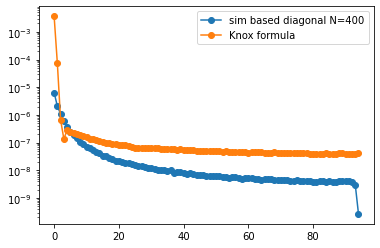

In [57]:
plt.semilogy(np.sqrt(np.diag(cov)), "-o", label="sim based diagonal N=400")
plt.semilogy(theory_err, "-o", label="Knox formula")
plt.legend()

### Clgg plots

In [9]:
ells, clgg = np.loadtxt("cmass_clgg_bandpowers.txt", unpack=True)

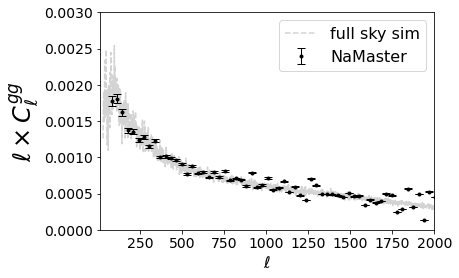

In [33]:
#plt.figure(figsize=(12,9))
clgg_sim = hp.alm2cl(galaxy_alm, galaxy_alm)
plt.ylim(0, 3e-3)
plt.xlim(10, 2000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"$\ell \times C_\ell^{gg}$", fontsize=24)
plt.plot(np.arange(30,3000), np.arange(30,3000) * (clgg_sim[30:3000] - 2.428e-7), '--', color='lightgrey', label='full sky sim')
plt.errorbar(ells[2:], ells[2:] * (clgg[2:]), yerr=ells[2:] * theory_err[2:],
             fmt='.k',linewidth=1, capsize=4, label="NaMaster")
plt.legend(prop={'size': 16})

In [25]:
clgg_sim = hp.alm2cl(galaxy_alm, galaxy_alm)

In [26]:
print(np.mean(clgg_sim[-10:]))

2.42805415754172e-07


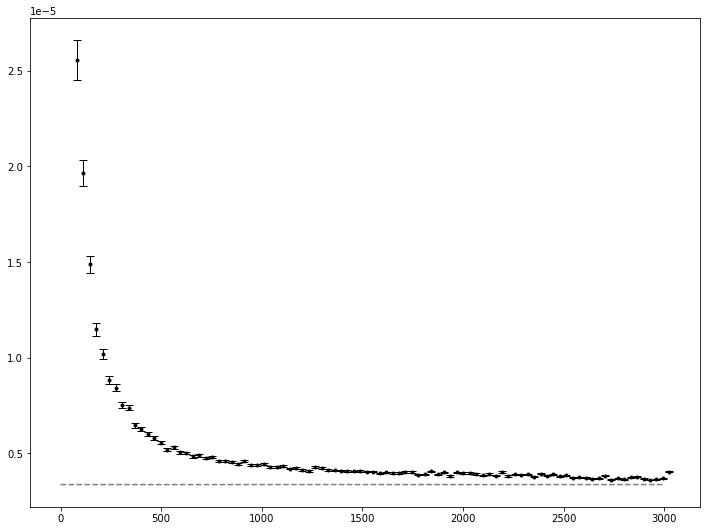

In [217]:
plt.figure(figsize=(12,9))
plt.errorbar(ells[2:], clgg[2:], yerr=theory_err[2:],
             fmt='.k',linewidth=1, capsize=4)
plt.plot(np.arange(3000), np.arange(3000)*0.+SN, '--', color='grey')

In [218]:
print(ells[:10], clgg[:10])

[ 17.5  49.5  81.5 113.5 145.5 177.5 209.5 241.5 273.5 305.5] [1.04482140e-04 3.37970623e-05 2.55671529e-05 1.96714108e-05
 1.48807525e-05 1.14711257e-05 1.02019631e-05 8.85309277e-06
 8.43133025e-06 7.51293322e-06]


In [219]:
zs, dndz = np.loadtxt("galaxy_DR12v5_CMASS_zs_dndz.txt", unpack=True)

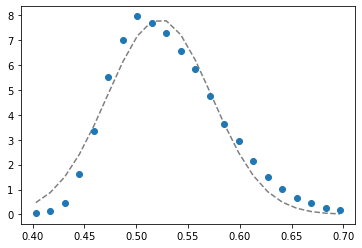

In [248]:
plt.plot(zs, gauss(zs, *coeff), '--', color='grey')
plt.plot(zs[np.logical_and(zs>0.4, zs<0.8)], dndz[np.logical_and(zs>0.4, zs<0.8)], 'o')

In [249]:
from scipy.optimize import curve_fit

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [8., 0.5, 0.1]

coeff, _ = curve_fit(gauss, zs, dndz, p0=p0)
dndz_mu, dndz_sigma = coeff[1], np.abs(coeff[2]) 

In [279]:
print(dndz_mu, dndz_sigma)

0.522474914602305 0.05040391263685186


In [233]:
zs, dndz = zs[np.logical_and(zs>0.4, zs<0.7)], dndz[np.logical_and(zs>0.4, zs<0.7)]

In [ ]:
#Get angular power spectrum for galaxy number counts 
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model, initialpower
lmax = 3000

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, omk=0.001)
pars.InitPower.set_params(As=2.101e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    GaussianSourceWindow(redshift=0.52, source_type='counts', bias=1.7,
                         sigma=0.01, dlog10Ndm=0.0)
    #SplinedSourceWindow(bias=1.5, dlog10Ndm=0.0, z=zs, W=dndz),
    #SplinedSourceWindow(bias=2.0, dlog10Ndm=0.0, z=zs, W=dndz),
    #SplinedSourceWindow(bias=2.5, dlog10Ndm=0.0, z=zs, W=dndz)
]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

cls_one = cls['W1xW1'][2:lmax+1] / (ls * (ls+1) / (2*np.pi))

#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
ls=  np.arange(2, lmax+1)
for spectrum in ['W1xW1']:
    plt.semilogy(ls, cls[spectrum][2:lmax+1], label=spectrum)

plt.errorbar(ells[4:], prefactor[4:]*(clgg[4:] - analytic_sn), yerr=prefactor[4:]*theory_err[4:],
             fmt='.k',linewidth=1, capsize=4)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();

In [ ]:
plt.

<ErrorbarContainer object of 3 artists>

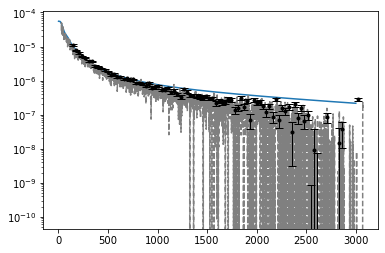

In [272]:
plt.semilogy(ls, cls['W1xW1'][2:lmax+1] / (ls * (ls+1) / (2*np.pi)))
plt.plot(np.arange(30,3073),(clgg_highell[30:] - SN), '--', color='grey')
plt.errorbar(ells[4:], clgg[4:] - analytic_sn, yerr=theory_err[4:],
             fmt='.k',linewidth=1, capsize=4)

In [273]:
print(ells[1:16])

[ 49.5  81.5 113.5 145.5 177.5 209.5 241.5 273.5 305.5 337.5 369.5 401.5
 433.5 465.5 497.5]


In [280]:
theory_err[1]

1.7723166231337717e-06

<ErrorbarContainer object of 3 artists>

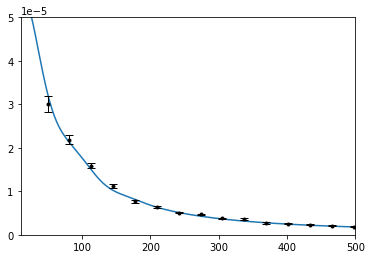

In [274]:
plt.xlim(10, 500)
plt.ylim(0, 5e-5)
plt.plot(ls, cls['W1xW1'][2:lmax+1] / (ls * (ls+1) / (2*np.pi)))
plt.errorbar(ells[1:16], clgg[1:16] - analytic_sn, yerr=theory_err[1:16],
             fmt='.k',linewidth=1, capsize=4)

In [202]:
np.savetxt("cmass-theory-cls.txt", np.column_stack((np.arange(lmax+1), np.append(np.zeros(2),
                                                                                 cls['W1xW1'][2:lmax+1] / (ls * (ls+1) / (2*np.pi))))))